In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download kkhandekar/random-image-for-testing-classification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
random-image-for-testing-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import os
path = '/content/datasets'
try:
    os.mkdir(path)
except OSError as error:
    print(error)

In [ ]:
import zipfile
with zipfile.ZipFile("random-image-for-testing-classification.zip","r") as zip_ref:
    zip_ref.extractall("/content/datasets")
import shutil
shutil.rmtree('/content/datasets/flowers')

In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio, display
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
import os
from os import path

path_to_directory = "/content/datasets/"
keyword = []

for f in os.listdir(path_to_directory):
    name , extension = path.splitext(f)
    keyword.append(name)
keyword

['street',
 'mountain',
 'forest',
 'glacier',
 'flower',
 'fish',
 'cat',
 'person',
 'motorbike',
 'house',
 'dog',
 'car',
 'sea',
 'fruit']

In [ ]:
import scipy
import IPython

def record_tebakan():
  audio, sr = get_audio()
  scipy.io.wavfile.write('tebakan.wav', sr, audio)
  IPython.display.Audio("tebakan.wav", autoplay=True)

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00


In [ ]:
import librosa
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer, Wav2Vec2CTCTokenizer
import warnings

def stt():
  audio, rate = librosa.load("tebakan.wav", sr = 16000)
  tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
  model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
  input_values = tokenizer(audio, return_tensors = "pt").input_values
  logits = model(input_values).logits
  prediction = torch.argmax(logits, dim = -1)
  transcription = tokenizer.batch_decode(prediction)[0]
  transcription = transcription.lower()
  warnings.filterwarnings('ignore')
  return transcription

In [ ]:
os.listdir(path_to_directory)

['street.jpg',
 'mountain.jpg',
 'forest.jpg',
 'glacier.jpg',
 'flower.jpg',
 'fish.jpg',
 'cat.jpg',
 'person.jpg',
 'motorbike.jpg',
 'house.jpg',
 'dog.jpg',
 'car.jpg',
 'sea.jpg',
 'fruit.jpg']

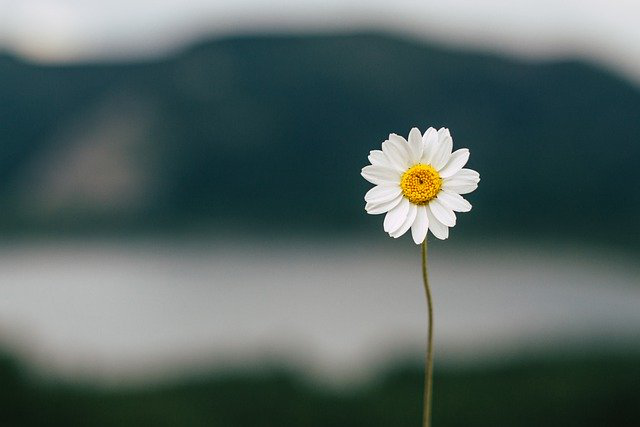

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You guessed its flower wen the lin
Your guess is false!
You got 0 point.
The correct answer is flower
Total Point = 0



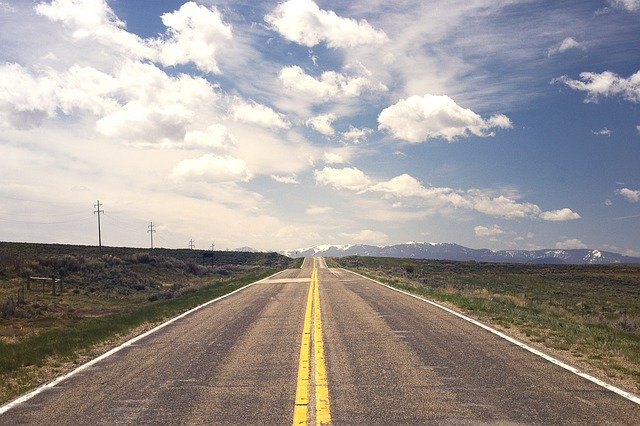

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You guessed its rod histry oufe
Your guess is false!
You got 0 point.
The correct answer is street
Total Point = 0



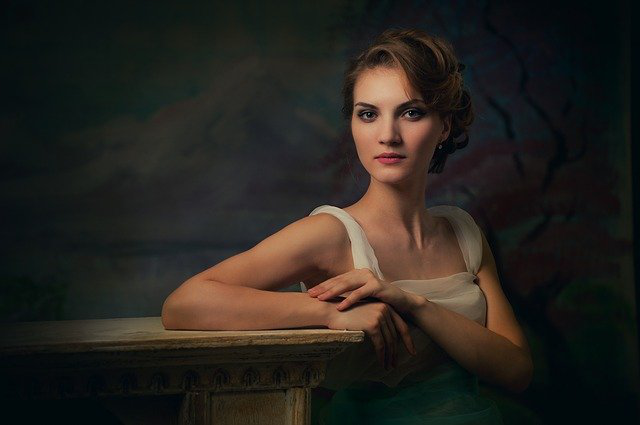

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You guessed its gogwman
Your guess is false!
You got 0 point.
The correct answer is person
Total Point = 0



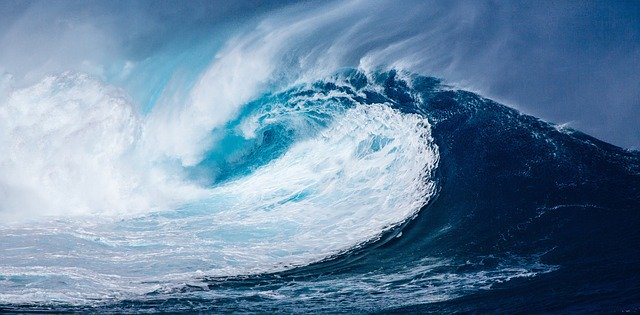

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You guessed its waife
Your guess is false!
You got 0 point.
The correct answer is sea
Total Point = 0



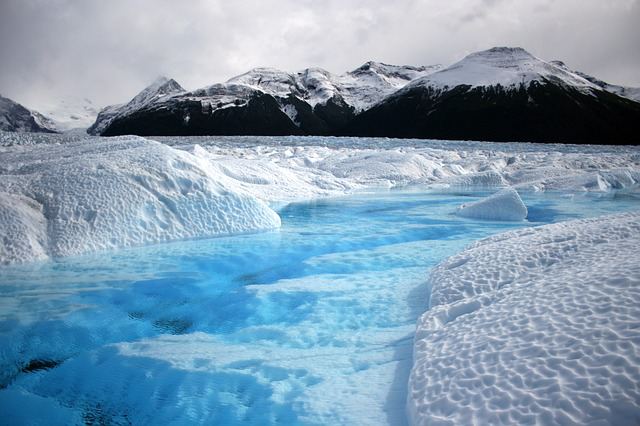

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You guessed its o you leasure
Your guess is false!
You got 0 point.
The correct answer is glacier
Total Point = 0

Game Ended! Congratulations your final point is 0


In [ ]:
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import random
point = 0
idx_done = []
while len(idx_done) < 5:
  img_idx = random.randrange(0, 13)
  if img_idx not in idx_done:
    idx_done.append(img_idx)
    im1 = Image.open(path_to_directory + os.listdir(path_to_directory)[img_idx])
    im1.show()
    record_tebakan()
    transcription = stt()
    print("You guessed its", transcription)
    if keyword[img_idx] == transcription:
      point += 1
      print("Your guess is right!")
      print("You got 1 point.")
    elif keyword[img_idx] != transcription:
      print("Your guess is false!")
      print("You got 0 point.")
      print("The correct answer is", keyword[img_idx])
    print("Total Point =", point)
    print()
print("Game Ended! Congratulations your final point is", point)